# Imports

In [1]:
from tsai.all import *
my_setup()

os              : Windows-10-10.0.19045-SP0
python          : 3.10.11
tsai            : 0.3.7
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 1.13.1+cu117
device          : 1 gpu (['NVIDIA GeForce RTX 3060 Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 31.69 GB
GPU memory      : [6.0] GB


# Dataset

## UCI Electricity 

In [2]:
# https://forecastingdata.org/
# https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014
# dsid = "electricity"
# try:
#     df = get_long_term_forecasting_data(
#         dsid, target_dir='datasets/forecasting/', 
#         force_download=False, return_df=True
#     )
#     print(f"{dsid:15}: {str(df.shape):15}")
#     remove_dir('./data/forecasting/', False)
# except Exception as e:
#     print(f"{dsid:15}: {str(e):15}")

electricity    : (26304, 322)   ██████████| 100.01% [54001664/53995526 00:05<00:00]


In [2]:
from tsai.data.external import get_Monash_forecasting_data
import pandas as pd

In [3]:
dsid = "electricity_hourly_dataset"
try:
    df = get_Monash_forecasting_data(
        dsid, path='datasets/forecasting/'
    )
    print(f"{dsid:15}: {str(df.shape):15}")
    # del df; gc.collect()
    # remove_dir('datasets/forecasting/', False)
except Exception as e:
    print(f"{dsid:15}: {str(e):15}")

Dataset: electricity_hourly_dataset
converting data to dataframe...
...done

freq                   : hourly
forecast_horizon       : 168
contain_missing_values : False
contain_equal_length   : True

exploding dataframe...
...done


data.shape: (8443584, 3)
electricity_hourly_dataset: (8443584, 3)   


In [4]:
def add_time_encoding(data:pd.DataFrame, time_column:str="date"):
    df = data.copy()

    date = pd.to_datetime(df[time_column])
    earliest_date = date.min()

    delta = (date - earliest_date).dt
    df['hours_from_start'] = delta.seconds  / 60 / 60 + delta.days * 24
    # df['days_from_start'] = delta.days
    df['hour'] = date.dt.hour
    df['day'] = date.dt.day
    df['weekday'] = date.dt.weekday
    df['month'] = date.dt.month

    return df

In [5]:
time_column = 'timestamp'
id_column = 'series_name'
target_column = 'series_value'

df = df[df[time_column] >= pd.to_datetime('2012-01-01')].reset_index(drop=True)
df.head()

,series_name,timestamp,series_value
0,T1,2012-01-01 00:00:01,14.0
1,T1,2012-01-01 01:00:01,18.0
2,T1,2012-01-01 02:00:01,21.0
3,T1,2012-01-01 03:00:01,20.0
4,T1,2012-01-01 04:00:01,22.0


In [6]:
df = add_time_encoding(df, time_column='timestamp')
df.to_csv('datasets/forecasting/electricity_hourly_dataset.csv', index=False)

In [107]:
def summary(df:pd.DataFrame, time_column, id_column):
    T = df[time_column].nunique()
    n_ids = df[id_column].nunique()
    n_samples = df.shape[0]

    output = f"\
    The dataset has {T} time steps, {n_ids} ids.\n\
    Sample size {n_samples}, per user {n_samples/n_ids}.\n\
    Start {df[time_column].min()}, end {df[time_column].max()}.\n"
    
    print(output)

In [106]:
summary(df, time_column, id_column)

    The dataset has 26304 time steps, 321 ids.
    Sample size 8443584, per user 26304.0.
    Start 2012-01-01 00:00:01, end 2014-12-31 23:00:01.



In [91]:
df.head(3)

,series_name,timestamp,series_value,hours_from_start,hour,day,weekday,month
0,T1,2014-01-01 00:00:01,12.0,0.0,0,1,2,1
1,T1,2014-01-01 01:00:01,13.0,1.0,1,1,2,1
2,T1,2014-01-01 02:00:01,13.0,2.0,2,1,2,1


In [11]:
fcst_history = 168
fcst_horizon = 24
stride = 1
valid_size=0.1
test_size=0.2

In [7]:
x_vars = [col for col in df.columns if col not in [time_column, id_column, target_column]]
y_vars = target_column
print(x_vars, y_vars)

['hours_from_start', 'hour', 'day', 'weekday', 'month'] series_value


In [118]:
from tsai.data.preparation import prepare_forecasting_data
from tsai.data.validation import get_forecasting_splits

In [8]:
temp = df[df[id_column].isin([f'T{num}' for num in range(301, 304)])]
print(temp.shape)

(78912, 8)


In [9]:
from fastai.learner import Learner
from tsai.models import FCN
from tsai.all import *
from fastai.metrics import mse, mae

# https://docs.fast.ai/callback.tracker.html
from fastai.callback.tracker import EarlyStoppingCallback, ReduceLROnPlateau, SaveModelCallback
from tsai.utils import cat2int

In [328]:
cat_names = [] # ['series_name']
cont_names = ['hours_from_start', 'hour', 'day', 'weekday', 'month', target_column]

for feature in cat_names:
    temp[feature] = cat2int(temp[feature].astype(str).values)

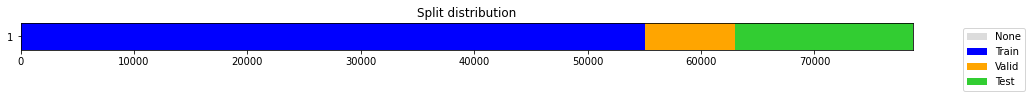

In [12]:
X, y = prepare_forecasting_data(
    temp, fcst_history, fcst_horizon, 
    x_vars=x_vars, y_vars=target_column
)
splits = get_forecasting_splits(
    temp, fcst_history, fcst_horizon, valid_size=valid_size, 
    test_size=test_size, show_plot=True
)

In [32]:
# We'll use inplace=True to preprocess data at dataset initialization. 
# This will significantly speed up training.
from tsai.data.core import TSDatasets, TSDataLoaders
from tsai.data.preprocessing import TSStandardize

tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
batch_size = 64

datasets = TSDatasets(X, y, splits=splits, tfms=tfms)
dataloaders  = TSDataLoaders.from_dsets(
    datasets.train, datasets.valid, bs=[batch_size, batch_size*2],
    batch_tfms=batch_tfms, 
    # num_workers=0
)

arch: TSTPlus(c_in=5 c_out=1 seq_len=168 arch_config={} kwargs={'custom_head': functools.partial(<class 'tsai.models.layers.lin_nd_head'>, d=[1, 24])})


SuggestedLRs(valley=0.04786301031708717)

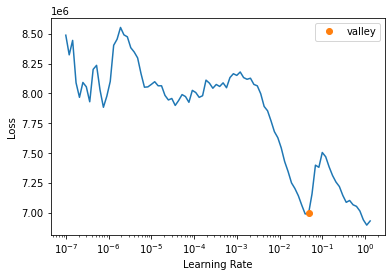

In [54]:
callbacks = [
    ReduceLROnPlateau(factor=0.5, min_lr=1e-6),
    EarlyStoppingCallback(patience=5),
    # SaveModelCallback()
]
archs = {
    'LSTMPlus': {'n_layers':3, 'bidirectional': True}
}
model = create_model(TSTPlus, dls=dataloaders, verbose=True)
learner = Learner(
    dataloaders, model, metrics=[mse, mae]
)
learner.lr_find()

In [55]:
learner.fit(n_epoch=10, lr=1e-3, cbs=callbacks)
gc.collect()

epoch,train_loss,valid_loss,mse,mae,time
0,2893242.750000,33424628.000000,33424628.000000,4935.940918,01:31
1,2916043.750000,35351892.000000,35351892.000000,5150.010742,03:49
2,2981291.500000,33067046.000000,33067046.000000,4932.229004,03:51
3,2908789.750000,33899084.000000,33899084.000000,5003.193359,04:06
4,3033225.000000,34537444.000000,34537444.000000,5049.706055,04:20
5,2969528.750000,33934708.000000,33934708.000000,4960.640137,04:21
6,3303880.250000,36272200.000000,36272200.000000,4989.996094,03:13
7,3163850.000000,36075752.000000,36075752.000000,5165.191895,04:09


No improvement since epoch 2: early stopping


30076

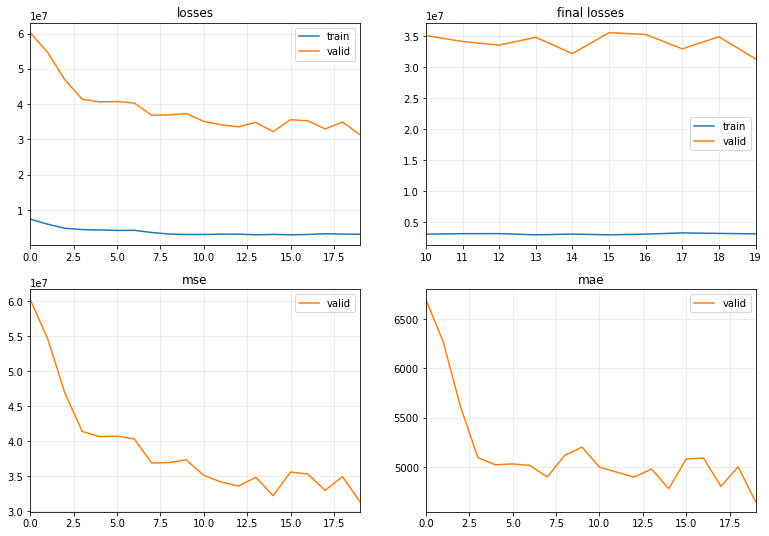

In [40]:
learner.plot_metrics()

In [41]:
X_train, y_train, X_val, y_val, X_test, y_test = split_Xy(X, y, splits)

In [299]:
preds = learner.get_preds(0, with_decoded=False)

In [300]:
y_train, preds[0]

array([[[ 24.,  22.,  22., ...,  56.,  66.,  52.]],

       [[ 22.,  22.,  20., ...,  66.,  52.,  20.]],

       [[ 22.,  20.,  22., ...,  52.,  20.,  23.]],

       ...,

       [[132., 122., 133., ...,  99., 142., 147.]],

       [[122., 133., 129., ..., 142., 147., 123.]],

       [[133., 129., 123., ..., 147., 123., 123.]]], dtype=float32)

In [42]:
_, _, preds = learner.get_X_preds(X_test)

In [50]:
y_preds = np.reshape(preds, y_test.shape)

In [52]:
y_preds[0], y_test[0]

(array([[2586.70288086, 2968.31591797, 3197.52416992, 3346.09301758,
         3476.81274414, 3597.73413086, 3561.25561523, 3394.43505859,
         3087.15185547, 2682.01269531, 2252.69238281, 1835.6607666 ,
         1400.54528809, 1097.96679688,  926.84667969,  816.6517334 ,
          701.20263672,  601.66210938,  547.01208496,  628.43530273,
          918.94256592, 1302.46643066, 1699.14001465, 2150.11206055]]),
 array([[7366., 7730., 8074., 8118., 8041., 8313., 8051., 8610., 8490.,
         9038., 9291., 9104., 9117., 5682., 2629., 2349., 2255., 2184.,
         2180., 2162., 2423., 2718., 2761., 3229.]], dtype=float32))

In [49]:
len(preds)

15735